In [1]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
import pandas as pd
from bs4 import BeautifulSoup
import requests
from newspaper import Article


C:\Users\biehl\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# For Topic Modeling
import gensim
from gensim import corpora, models
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models import FastText

import numpy as np
import os
from random import shuffle
import re
import matplotlib.pyplot as plt 
import numpy as np
import pyLDAvis
import pyLDAvis.gensim

In [16]:
from collections import Counter

In [3]:
# Loading our two pipelines
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

config = {"punct_chars": [".", "?", "!", "。"]}
nlp.add_pipe('sentencizer')

In [4]:
# Using panda to load in our .csv file
df = pd.read_csv("urls.csv") # File we are checking
urls = df["Address"].tolist() # Column name we are checking
url_sent_score = []
url_sent_label = []
url_subj_score = []
url_subj_label = []
total_pos = []
total_neg = []
topic_sentiment = []

In [5]:
def get_named_entities(doc):
    ent_list = []
    for ent in doc.ents:
        ent_list.append((ent.text,ent.label_))
    return ent_list

def get_sentences(doc):
    return doc.sents

def get_sentence_list(doc):
    return [sent for sent in doc.sents]

#Takes a doc object from spacy and returns a tuple list of form (sentence, sentiment of sentence) for all sentences
def sentence_sentiment_from_doc(doc):
    sentences = get_sentences(doc)
    tuple_list = []
    for sentence in sentences:
        sent_doc = nlp(sentence.text)
        tuple_list.append((sentence.text,sent_doc._.blob.polarity))
    return tuple_list

#Finds all named entities (does not filter by person, date, etc) and returns sentiment value based on the sentences they
#are included in. Returns dictionary of form {entity name : sentiment value}
def sentence_sentiment_on_named_entities(doc):
    named_ent_list = get_named_entities(doc)
    sentence_sentiment_list = sentence_sentiment_from_doc(doc)
    return_dict = {}
    
    for (name, label) in named_ent_list:
        #print(name, "\n")
        #print(type(name))
        return_dict[name] = 0
        
        for (sentence, sentiment) in sentence_sentiment_list:
             if sentence.find(name) != -1:
                    #print(name,sentence)
                    return_dict[name] += sentiment
    
    return return_dict

#takes in a single topic word, the word's weight, and the doc, and returns sentiment of that word within the doc
def sentence_level_sentiment_of_word(word, weight, doc):
    sentence_sentiment_list = sentence_sentiment_from_doc(doc)
    sentiment_total = 0
    
    for (sentence, sentiment) in sentence_sentiment_list:
             if sentence.find(word) != -1:
                    #print(name,sentence)
                    sentiment_total += sentiment
    return sentiment_total

def weighted_word_sentiment(word,weight, doc):
    sentiment = sentence_level_sentiment_of_word(word, weight, doc)
    weighted_sentiment = sentiment * weight
    return weighted_sentiment

In [25]:
def detect_url_error(text):
    if len(text) < 1000 or most_repeated_phrase_count(text) >= 3:
        return 0

def get_doc(url):
    article = Article(url)
    article.download()
    article.parse()
    
    if detect_url_error(article.text) == 0:
        return 0


    page_text = (article.text).lower()
    page_text = page_text.strip().replace("  ","")
    page_text = "".join([s for s in page_text.splitlines(True) if s.strip("\r\n")])
    
    # Start the sentiment analysis now
    doc = nlp(page_text)
    return doc

def most_repeated_phrase_count(text):
    # Split the text into phrases (e.g., sentences)
    phrases = re.split(r'\.', text)

    # Remove leading and trailing spaces from each phrase
    phrases = [phrase.strip() for phrase in phrases if phrase.strip()]

    # Count the occurrences of each phrase using Counter
    phrase_counts = Counter(phrases)

    if not phrase_counts:
        return 0

    # Find the most common phrase and its count
    most_common_phrase, count = phrase_counts.most_common(1)[0]

    return count

The most repeated phrase appears 1 times.


In [26]:
#https://pypi.org/project/spacytextblob/
for count, x in enumerate(urls):
    if(count % 10 == 0):
        print(count)
    try:
        url = x
        
        
#         headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36'}
#         res = requests.get(url,headers=headers)
#         html_page = res.text

#         soup = BeautifulSoup(html_page, 'html.parser')
#         for script in soup(["script", "style","meta","label","header","footer"]):
#             script.decompose()
#         page_text = (soup.get_text()).lower()
#         page_text = page_text.strip().replace("  ","")
#         page_text = "".join([s for s in page_text.splitlines(True) if s.strip("\r\n")])
        
        doc = get_doc(url)
        sentiment = doc._.blob.polarity
        sentiment = round(sentiment,2)
        subjectivity = doc._.blob.subjectivity
        subjectivity = round(subjectivity,2)
        
#         if count / 3 == 1:
#             print("enter test spot\n")
#             #ent_list = get_named_entities(doc)
#             #print(ent_list)
#             sentence_sentiment_list = sentence_sentiment_from_doc(doc)
#             #sent_1 = sentence_sentiment_list.pop()
#             #print(sent_1)
#             #print(type(sent_1[0]))
#             print(sentence_sentiment_list)
#             topic_level_sentiment = sentence_sentiment_on_named_entities(doc)
#             #print(topic_level_sentiment)
#             print(sentence_level_sentiment_of_word('kansas',0,doc))
#             break
            
        #print("\n")

        # Gives positive or negative label
        if sentiment >= -0.033 and sentiment <= 0.043:
            sent_label = "Neutral"
        elif sentiment > 0.043 and sentiment < 0.143:
            sent_label = "Neutral Positive"
        elif sentiment > 0.143:
            sent_label = "Positive"
        elif sentiment < -0.033 and sentiment > -0.062:
            sent_label = "Neutral Negative"
        elif sentiment < -0.062:
            sent_label = "Negative"

        #Document's topic-level sentiment assessment of named entities
        topic_level_sentiment = sentence_sentiment_on_named_entities(doc)
        topic_sentiment.append(topic_level_sentiment)
        
        #Adding label, sentiment, subjectivity of document
        url_sent_label.append(sent_label)
        url_sent_score.append(sentiment)
        url_subj_score.append(subjectivity)

        positive_words = []
        negative_words = []

        for x in doc._.blob.sentiment_assessments.assessments:
          if x[1] > 0:
            positive_words.append(x[0][0])
          elif x[1] < 0:
            negative_words.append(x[0][0])
          else:
            pass

        total_pos.append(', '.join(set(positive_words)))
        total_neg.append(', '.join(set(negative_words)))
    except:
        url_sent_label.append("Error")
        url_sent_score.append(0.0)
        url_subj_score.append(0.0)
        topic_sentiment.append({'Error':0})

        positive_words = []
        negative_words = []

        total_pos.append(', '.join(set(positive_words)))
        total_neg.append(', '.join(set(negative_words)))

print("The average sentiment score was: " + str(sum(url_sent_score) / len(url_sent_score)))
print("The average subjectivity score was: " + str(sum(url_subj_score) / len(url_subj_score)))

df["Sentiment Score"] = url_sent_score
df["Sentiment Label"] = url_sent_label
df["Subjectivity Score"] = url_subj_score
df["Positive Words"] = total_pos
df["Negative Words"] = total_neg
df["Topic Sentiment"] = topic_sentiment

df

0
10


c:\Users\biehl\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(
c:\Users\biehl\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(


20


c:\Users\biehl\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(


30


c:\Users\biehl\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(


40


c:\Users\biehl\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(


50
60


c:\Users\biehl\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(


70


c:\Users\biehl\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(


80


c:\Users\biehl\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(
c:\Users\biehl\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(


90
100
110


c:\Users\biehl\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(


120
The average sentiment score was: 0.027692307692307686
The average subjectivity score was: 0.18234615384615396


ValueError: Length of values (260) does not match length of index (130)

In [27]:
# store as list of lists of words
def preprocess_article(doc):
    x = get_sentence_list(doc)
    input_text = [str(sentence) for sentence in x]

    # Set a minimum word length threshold
    min_word_length = 3

    sentences_ted = []
    for sent_str in input_text:
        tokens = re.sub(r"[^a-z]+", " ", sent_str.lower()).split()
        tokens = [token for token in tokens if not token.isdigit()]
        tokens = [token for token in tokens if len(token) >= min_word_length]
        sentences_ted.append(tokens)

    stoplist = []
    with open('stopwords') as openfileobject:
        for line in openfileobject:
            stoplist.append(line[:-1])
    stoplist = set(stoplist)

    for i in range(len(sentences_ted)):
        for word in reversed(sentences_ted[i]):
            if word in stoplist:
                sentences_ted[i].remove(word)
    return sentences_ted

In [28]:
preprocessed_articles = [
    
]
x = 0
for count, url in enumerate(urls):
    try:
        x += 1
        text = get_doc(url)
        if text != 0:
            preprocessed_articles.append(preprocess_article(text))
    except:
        pass

all_text = []
for corpus in preprocessed_articles:
    for word in corpus:
        all_text.append(word)
dictionary = Dictionary(all_text)
dictionary.filter_extremes(no_below=0.1, no_above=0.9)
bow_corpora = []

for corpus in preprocessed_articles:
    bow_corpus = ([dictionary.doc2bow(sentence) for sentence in corpus])
    for bow in bow_corpus:
        bow_corpora.append(bow)
print(x)

c:\Users\biehl\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(
c:\Users\biehl\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(
c:\Users\biehl\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(
c:\Users\biehl\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\utils.py:488: Deprecatio

130


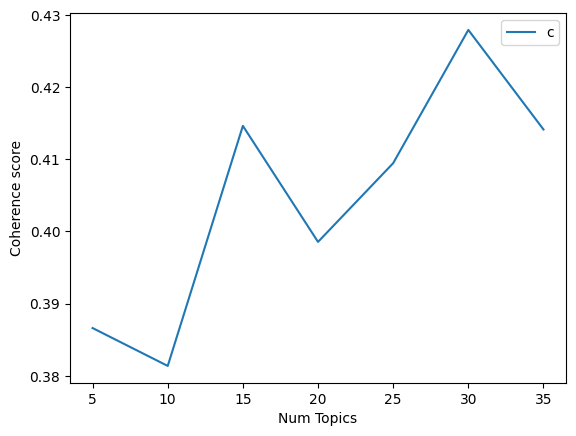

In [29]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
        #model = gensim.models.ldamulticore.LdaMulticore(corpus, num_topics = num_topics, id2word=dictionary,random_state=100,passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpora, texts=all_text, start=5, limit=40, step=5)
# Show graph
limit=40; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [30]:
best_result_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_index]
# Select the model and print the topics
model_topics = optimal_model.show_topics(formatted=False)
print(f'''The {x[best_result_index]} topics gives the highest coherence score 
of {coherence_values[best_result_index]}''')

The 30 topics gives the highest coherence score 
of 0.4279576802750848


In [31]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(optimal_model, bow_corpora, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5     -0.075812  0.007151       1        1  5.713261
26    -0.128946 -0.034430       2        1  4.988904
13    -0.117975 -0.085690       3        1  4.730560
17    -0.063570 -0.069782       4        1  4.551407
0     -0.064178 -0.085013       5        1  4.310923
19     0.203978 -0.232900       6        1  4.095789
7     -0.002746  0.021734       7        1  4.058506
3      0.015257  0.053430       8        1  3.964477
28    -0.026070  0.021637       9        1  3.762216
25    -0.003256  0.042122      10        1  3.700192
27     0.014446  0.013397      11        1  3.476526
22     0.022757  0.017717      12        1  3.423658
1     -0.081997 -0.036908      13        1  3.422579
12    -0.019030 -0.050706      14        1  3.333634
29    -0.006725  0.041071      15        1  3.289768
18     0.037847  0.046035      16        1  3.120822
4      0.032957  0.014222      17        1  3.116088
21    -0.035070  0.000009      18        1  2.878047
20    -0.033109  0.009771      19        1  2.858058
14     0.012310  0.045367      20        1  2.829528
8     -0.025289 -0.039064      21        1  2.774321
24     0.061801  0.064418      22        1  2.698697
10     0.008554 -0.039662      23        1  2.637667
11    -0.013637  0.044587      24        1  2.544229
16     0.028085  0.026828      25        1  2.541031
15    -0.022896  0.010551      26        1  2.510413
23     0.111450  0.023110      27        1  2.313184
6      0.053496  0.070842      28        1  2.270894
2      0.066682  0.051288      29        1  2.268579
9      0.050685  0.048868      30        1  1.816044, topic_info=          Term       Freq      Total Category  logprob  loglift
1626       vax  38.000000  38.000000  Default  30.0000  30.0000
953       days  39.000000  39.000000  Default  29.0000  29.0000
2131    cancer  30.000000  30.000000  Default  28.0000  28.0000
2142     vaers  23.000000  23.000000  Default  27.0000  27.0000
1158       air  69.000000  69.000000  Default  26.0000  26.0000
...        ...        ...        ...      ...      ...      ...
2580     great   0.727655   6.951869  Topic30  -6.1962   1.7516
1162       get   0.727047  52.642460  Topic30  -6.1970  -0.2738
2881  attended   0.726671   3.029886  Topic30  -6.1975   2.5807
195      biden   0.726301  46.337420  Topic30  -6.1980  -0.1472
552     enough   0.726250   6.139684  Topic30  -6.1981   1.8739

[2170 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2280      6  0.260847  abdomen
2280     29  0.521694  abdomen
1441      7  0.209419  ability
1441      8  0.209419  ability
1441      9  0.209419  ability
...     ...       ...      ...
2934     30  0.261081    youth
2178     10  0.635272      yrs
2632     23  0.331208     zero
2632     26  0.331208     zero
4615     21  0.649155     zlem

[5819 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 27, 14, 18, 1, 20, 8, 4, 29, 26, 28, 23, 2, 13, 30, 19, 5, 22, 21, 15, 9, 25, 11, 12, 17, 16, 24, 7, 3, 10])

In [32]:
for topic_id, topic_words in model_topics:
    print("Topic: " + str(topic_id))
    weighted_topic_sentiment = 0
    word_sentiment_list = []
    for word, weight in topic_words:
        word_sentiment_list.append(weighted_word_sentiment(word, weight, doc))
    for sentiment in word_sentiment_list:
        weighted_topic_sentiment += sentiment
    weighted_topic_sentiment /= len(word_sentiment_list) /100
    print("Topic Words: " + str(topic_words))
    print("Sentiment = " + str(weighted_topic_sentiment))

Topic: 27
Topic Words: [('vaccine', 0.019588357), ('said', 0.010888968), ('navy', 0.008119142), ('military', 0.008111845), ('order', 0.006766785), ('covid', 0.0056753773), ('emergency', 0.005671568), ('severe', 0.0046579116), ('similar', 0.004635094), ('defense', 0.0044210725)]
Sentiment = 0.05444483831524849
Topic: 5
Topic Words: [('members', 0.017779088), ('service', 0.013238899), ('duty', 0.011106686), ('active', 0.010941828), ('vaccinated', 0.009339576), ('covid', 0.008127534), ('get', 0.007587291), ('new', 0.007385961), ('military', 0.0062690317), ('force', 0.0061915256)]
Sentiment = 0.06934953752594689
Topic: 4
Topic Words: [('would', 0.008961532), ('said', 0.007691056), ('one', 0.0075269863), ('military', 0.00678063), ('order', 0.006407949), ('force', 0.0058987536), ('vaccine', 0.0056980154), ('award', 0.0051433644), ('made', 0.0051433626), ('began', 0.0051364736)]
Sentiment = 0.038455280009657145
Topic: 25
Topic Words: [('vaccine', 0.008592843), ('new', 0.008080915), ('military

In [33]:
error_count = 0
f = open("topic_data.txt", "w")
for count, url in enumerate(urls):
    try:
        doc = get_doc(url)  # Load the document
        article = preprocess_article(doc)  # Preprocess and convert to bag-of-words
        bow_doc = ([dictionary.doc2bow(sentence) for sentence in article])
        topic_distribution = optimal_model.get_document_topics(bow_doc)  # Get the topic distribution
        for topic in topic_distribution[0]:
            topic_words = optimal_model.show_topic(topic[0])
            f.write(str(topic_words))
            f.write("\n")
        f.write(str(url))
        f.write("\n")
        f.write(str(doc))
        f.write("\n\n\n")
    except:
        error_count +=1

print("errors: ", error_count)

c:\Users\biehl\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(
c:\Users\biehl\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(
c:\Users\biehl\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(
c:\Users\biehl\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\utils.py:488: Deprecatio

errors:  85


In [34]:
for count, url in enumerate(urls):
    try:
        doc = get_doc(url)  # Load the document
        article = preprocess_article(doc)  # Preprocess and convert to bag-of-words
        bow_doc = ([dictionary.doc2bow(sentence) for sentence in article])
        topic_distribution = optimal_model.get_document_topics(bow_doc)  # Get the topic distribution
        for topic in topic_distribution:
            topic_words = optimal_model.show_topic(topic[0])
        print(topic_words)
        print(doc)
        print("\n\n\n")
    except:
        pass

c:\Users\biehl\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(
c:\Users\biehl\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(
c:\Users\biehl\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\utils.py:488: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  warnings.warn(
c:\Users\biehl\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\utils.py:488: Deprecatio